In [1]:
import csv
import yaml
import glob
import os
import json
import nltk
import re
import shutil
import string
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa
from tensorflow import keras
from keras import models, layers, preprocessing as kprocessing
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from random import sample
from collections import defaultdict
from swda import Transcript
from swda import CorpusReader
from operator import itemgetter
from statistics import mean

2022-04-30 04:47:37.948360: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-30 04:47:37.948378: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
datasets_path = 'data/preprocessed_datasets/'
res_intent_path = 'data/result_intents/'
res_hobbie_path = 'data/result_hobbies/'

if not os.path.exists(res_intent_path): os.makedirs(res_intent_path)
if not os.path.exists(res_hobbie_path): os.makedirs(res_hobbie_path)

final_intents = []
result = defaultdict(set)

In [3]:
intent_group = {
    'Answer my question' : 'answer_my_question',
    'fa' : 'im_sorry',
    'You Are Welcome' : 'you_are_welcome',
    'wait' : 'wait',
    'Sure' : 'are_you_sure',
    'mood_unhappy' : 'mood_unhappy',
    'mood_angry' : 'mood_angry',
    'mood_scared' : 'mood_scared',
    'mood_nervous' : 'mood_nervous',
    'mood_excited' : 'mood_excited',
    'mood_lonely' : 'mood_lonely',
    'mood_tired' : 'mood_tired',
    'Clever' : 'you_are_clever',
    'TimeQuery' : 'tell_me_time',
    'listOfGames' : 'list_of_games',
    'playOtherGame' : 'play_other_game',
    'volumeUp' : 'volume_up',
    'volumeDown' : 'volume_down',
    'WhoAmI' : 'who_am_i',
    'music_likeness' : 'music_likeness',
    'music_dislikeness' : 'music_dislikeness',
    'ba' : 'appreciation',
    'general_praise' : 'general_praise',
    'Reaction - Positive' : 'positive_reaction',
    'Reaction - Negative' : 'negative_reaction',
    'general_negate' : 'youre_not_correct',
    'NotTalking2U' : 'NotTalking2U'
}

for key in ['Bot Bad', 'Crazy', 'Annoying', 'Care the Language', 'Bad']:
    intent_group[key] = 'bot_bad'

for key in ['Thanks', 'Well Done', 'General - Thanks', 'ft']:
    intent_group[key] = 'thanks'

for key in ['Bot Affection', 'Good', 'Marry', 'Friend']:
    intent_group[key] = 'bot_affection'

for key in ['yesNode', 'Confirmation Yes', 'ny', 'General - Ok', 'aa']:
    intent_group[key] = 'yes_agree'
    
for key in ['Right', 'affirm_smalltalk', 'general_affirm']:
    intent_group[key] = 'affirm_correct'
    
for key in ['deny_smalltalk', 'noNode', 'General - Not', 'wrong', 'Confirmation No', 'nn']:
    intent_group[key] = 'no_deny_wrong'
    
for key in ['I do not care', 'Reaction - Indifferent', 'maybeNode', 'general_dontcare']:
    intent_group[key] = 'i_dont_care'
    
for key in ['Be clever', 'ad']:
    intent_group[key] = 'bot_action_directive'
    
for key in ['No Problem', 'Reaction - Understanding']:
    intent_group[key] = 'no_problem'
    
for key in ['stop', 'General - Stop', 'Confirmation Cancel', 'totalStop', 'Shutup', 'general_commandstop']:
    intent_group[key] = 'stop'
    
for key in ['greet_smalltalk', 'general_greet', 'Welcome', 'Good Morning', 'Good Evening', 'Greetings - Nice to see you', 'Greetings - Nice to talk to you', 'Greetings - Nice to meet you', 'Greeting']:
    intent_group[key] = 'greetings'
    
for key in ['goodbyes_smalltalk', 'Good Night', 'General - Bye', 'GoodBye', 'CourtesyGoodBye']:
    intent_group[key] = 'goodbye'
    
for key in ['How are you', 'Greetings - Whatsup', 'CourtesyGreeting']:
    intent_group[key] = 'how_are_you'
    
for key in ['Explain', 'general_explain']:
    intent_group[key] = 'explain'
    
for key in ['Repeat', 'general_repeat']:
    intent_group[key] = 'repeat'

for key in ['^g', 'bk', 'bh']:
    intent_group[key] = 'response_acknowledgement'
    
for key in ['There', 'stillThere', 'Ready']:
    intent_group[key] = 'are_you_there'
    
for key in ['Bot Identity', 'Author', 'Agent Name', 'NameQuery', 'RealNameQuery', 'SelfAware']:
    intent_group[key] = 'bot_identity'

for key in ['Acquaintance', 'Occupation', 'Bot Purpose']:
    intent_group[key] = 'bot_purpose'

for key in ['bot_challenge', 'Chatbot', 'Real']:
    intent_group[key] = 'bot_challenge'
    
for key in ['mood_happy', 'Enjoyment']:
    intent_group[key] = 'mood_happy'
    
for key in ['mood_bored', 'Boring']:
    intent_group[key] = 'mood_bored'
    
for key in ['Jokes', 'general_joke']:
    intent_group[key] = 'tell_me_joke'
    
for key in ['timesPlayed', 'gamesCounter']:
    intent_group[key] = 'times_played'

# Data processing

To process SWDA data, you need to place the original SWDA dataset in the root project folder (if you change swda topics) or the preprocessed version in data/preprocessed_datasets/ (if you do not change swda topics).\
\
To process other datasets, you need to put the preprocessed versions of them in data/preprocessed_datasets/ .

## 1. SWDA

In [4]:
swda_topics = ['VACATION SPOTS', 'MUSIC', 'BOOKS AND LITERATURE', 'CAMPING', 'MOVIES', 'PETS', 'FAMILY LIFE', 
              'EXERCISE AND FITNESS', 'HOBBIES AND CRAFTS', 'BASEBALL', 'FISHING', 'FOOTBALL', 'RESTAURANTS', 
              'BASKETBALL', 'GARDENING', 'PAINTING', 'GOLF', 'FAMILY REUNIONS', 'BOATING AND SAILING', 'WOODWORKING']
hobbies = [topic.replace(' ', '_') for topic in swda_topics]

In [5]:
### copy files with relevant topics

def copy_files():
    
    out_files_path = datasets_path + '1_SWDA/'
    if not os.path.exists(out_files_path):
        os.makedirs(out_files_path)

    old_metadata_path = 'swda/swda-metadata.csv'
    shutil.copy2(old_metadata_path, metadata_path) 
    metadata = csv.reader(open(metadata_path))
    header = next(metadata)

    for row in metadata:
        topic = row[3]

        if topic in swda_topics:
            swda_file_path = glob.glob('swda/*/*' + row[0] + '.utt.csv')

            if swda_file_path:
                shutil.copy2(swda_file_path[0], out_files_path + topic.replace(' ', '_') + '_' + row[0] + '.csv') 

In [6]:
#copy_files()

### Process hobbies

In [7]:
def write_hobbies():
    
    swda_act_dict = {
        "sv": "Statement-opinion",
        "sd": "Statement-non-opinion",
        "qy": "Yes-No-Question",
        "qy^d": "Declarative Yes-No-Question",
        "qw": "Wh-Question",
        "arp_nd": "Dispreferred answers",
    }
    
    for hobbie in hobbies:
        res_hobbies = defaultdict(set)
        hobbie_paths = glob.glob(files_path + hobbie + '*')

        for hobbie_path in hobbie_paths:
            trans = Transcript(hobbie_path, metadata_path)
            intent_n_examples = list(trans.utterances)

            for intent in intent_n_examples:
                intent_name = swda_act_dict.get(intent.damsl_act_tag(), 'irrelevant')

                if intent_name != 'irrelevant':
                    intent_text = intent.text
                    intent_text = re.sub("([\{\<\(]).*?([\}\>\)])", "", intent_text)
                    intent_text = re.sub("([/\[\]\(\)\<\>\+\-#])", "", intent_text)
                    intent_text = intent_text.replace('s1', '')
                    intent_text = intent_text.replace('s2', '')
                    intent_text = re.sub(" +", " ", intent_text)
                    intent_text = intent_text.lstrip(', .')
                    intent_text = intent_text.strip()

                    if len(intent_text) > 10 and re.search('[a-zA-Z]', intent_text):
                        res_hobbies[intent_name].add(intent_text)
        with open(res_hobbie_path + hobbie + '.yml', 'w') as outfile:
            yaml.dump(res_hobbies, outfile, default_flow_style=False)

In [8]:
def read_hobbies(file_path):
    
    with open(file_path, 'r') as stream:
        for x in range(4): next(stream)
        return yaml.safe_load(stream)

In [9]:
#write_hobbies()
#res_hobbies = defaultdict(set)
#res_hobbies = read_hobbies(res_hobbie_path + 'MUSIC.yml')
#res_hobbies['Statement-non-opinion']

### Process intents

In [10]:
def trim_intent(intent_text):
    result_intent = intent_text.lower()
    result_intent = re.sub("([\{\<\(]).*?([\}\>\)])", "", result_intent)
    result_intent = re.sub("([/,\.\[\]\(\)\<\>\+\-#])", "", result_intent)
    result_intent = result_intent.replace('s1', '')
    result_intent = result_intent.replace('s2', '')
    result_intent = result_intent.replace('olly', '')
    result_intent = re.sub(" +", " ", result_intent)
    result_intent = result_intent.strip()
    return result_intent

In [11]:
def process_1_swda():
    files_path = datasets_path + '1_SWDA/'
    metadata_path = files_path + 'swda-metadata.csv'

    for hobbie in hobbies:
        hobbie_paths = glob.glob(files_path + hobbie + '*')

        for hobbie_path in hobbie_paths:
            trans = Transcript(hobbie_path, metadata_path)
            intent_n_examples = list(trans.utterances)

            for intent in intent_n_examples:
                intent_name = intent_group.get(intent.damsl_act_tag(), 'irrelevant')

                intent_text = trim_intent(intent.text)

                if intent_name != 'irrelevant' and re.search('[a-zA-Z]', intent_text) and len(intent_text) < 50:
                    result[intent_name].add(intent_text)

## 2. RasaHQ

In [12]:
def process_2_rasaHQ():
    file_paths = glob.glob(datasets_path + '2_RasaHQ/*/*.yml')

    for file_path in file_paths:
        with open(file_path, 'r') as file:
            parsed_file = yaml.safe_load(file)

        intents_n_examples = parsed_file["nlu"]
        for intent in intents_n_examples:
            intent_name = intent_group.get(intent['intent'], 'irrelevant')
            rough_examples = intent['examples'].split('\n')
            examples = [trim_intent(ex) for ex in rough_examples][:-1]
            
            if intent_name != 'irrelevant':
                result[intent_name].update(examples)

## 3. Chatbot Dialog Dataset

In [13]:
def process_3_dialog_dataset():
    file_path = datasets_path + '3_Chatbot_Dialog_Dataset/'

    for file in os.listdir(file_path):
        intent_name = intent_group.get(str(file).split('.')[0], 'irrelevant')

        rough_examples = open(file_path + file, "r").read().split("\n")
        examples = [trim_intent(ex) for ex in rough_examples]
        
        if intent_name != 'irrelevant':
            result[intent_name].update(examples)

## 4. Chatbot Intent Classification

In [14]:
def process_4_intent_classification():
    file_path = datasets_path + '4_Chatbot_Intent_Classification/intent-corpus-basic.json'

    with open(file_path, 'r') as file:
        data = json.load(file)

    intents_n_examples = data['sentences']
    for intent in intents_n_examples:
        intent_name = intent_group.get(intent['intent'], 'irrelevant')
        example = trim_intent(intent['text'])

        if intent_name != 'irrelevant' and re.search('[a-zA-Z]', example):
            result[intent_name].add(example)

## 5. Chatbot Intent Recognition

In [15]:
def process_5_intent_recognition():    
    file_path = datasets_path + '5_Chatbot_Intent_Recognition/Intent.json'

    with open(file_path, 'r') as file:
        data = json.load(file)

    intents_n_examples = data['intents']
    for intent in intents_n_examples:
        intent_name = intent_group.get(intent['intent'], 'irrelevant')

        rough_examples = intent['text']
        examples = [trim_intent(ex) for ex in rough_examples]
        
        if intent_name != 'irrelevant':
            result[intent_name].update(examples)

## 6. HWU64

In [16]:
def process_6_hwu64():
    file_path = datasets_path + '6_HWU64/NLU-Data-Home-Domain-Annotated-All.csv'

    file = open(file_path)    
    data = csv.reader(file)

    header = next(data)

    for row in data:
        clean_row = ','.join(map(str, row)).split(';')
        intent_name = intent_group.get(clean_row[2] + "_" + clean_row[3], 'irrelevant')
        example = trim_intent(clean_row[9])

        if intent_name != 'irrelevant' and re.search('[a-zA-Z]', example):
            result[intent_name].add(example)

In [17]:
### write intents

def write_results():
    for intent_group in result.keys():
        with open(res_intent_path + intent_group + '.yml', 'w') as outfile:
            yaml.dump(result[intent_group], outfile, default_flow_style=False)

In [18]:
#process_1_swda()
#process_2_rasaHQ()
#process_3_dialog_dataset()
#process_4_intent_classification()
#process_5_intent_recognition()
#process_6_hwu64()
#write_results()

# Transfer learning

In [19]:
def read_intents(file_path):  
    with open(file_path, 'r') as stream:
        return yaml.safe_load(stream)

In [20]:
result = defaultdict(set)

file_paths = glob.glob(res_intent_path + '*.yml')

for file_path in file_paths:

    intents = read_intents(file_path)
    intent_group = file_path.replace(res_intent_path, '').replace('.yml', '')
    result[intent_group] = intents

In [21]:
# get intent groups and number of samples in each group. 
# (only if the group is bigger than 55 samples)
intent_group_n = [(len(result[key]), key) for key in result.keys() if len(result[key]) > 55]
intent_group_n.sort(key=lambda key: key[0])
print('number of intents:', len(intent_group_n))
print('smallest sets:', intent_group_n[:5])
print('biggest sets:', intent_group_n[-5:])
intent_groups = [key[1] for key in intent_group_n]

number of intents: 27
smallest sets: [(61, 'bot_identity'), (66, 'list_of_games'), (68, 'thanks'), (74, 'volume_up'), (91, 'bot_purpose')]
biggest sets: [(601, 'repeat'), (627, 'general_praise'), (633, 'explain'), (939, 'youre_not_correct'), (956, 'yes_agree')]


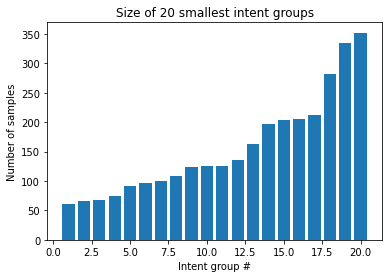

In [22]:
plt.bar(range(1,21), [key[0] for key in intent_group_n][:20])
plt.title('Size of 20 smallest intent groups')
plt.ylabel('Number of samples')
plt.xlabel('Intent group #')
plt.show()

In [23]:
interjections = ['hmm ', 'ah ', 'oh ', 'uh ', 'uhh ', 'hey ']

for group_n in intent_group_n:
    if group_n[0] < 250:
        frac = 0.95 if group_n[0] < 150 else 0.55
        group_name = group_n[1]
        new_samples = sample(result[group_name], int(frac * group_n[0]))
        new_samples_aug = [sample(interjections, 1)[0] + samp for samp in new_samples]
        result[group_name].update(new_samples_aug)

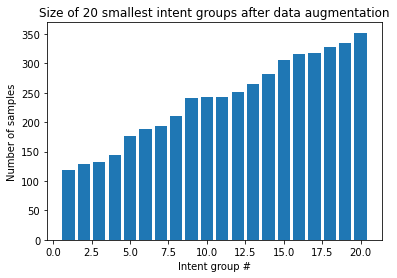

In [24]:
augmented_data_stats = [len(result[key]) for key in result.keys() if len(result[key]) > 55]
augmented_data_stats.sort()

plt.bar(range(1,21), augmented_data_stats[:20])
plt.title('Size of 20 smallest intent groups after data augmentation')
plt.ylabel('Number of samples')
plt.xlabel('Intent group #')
plt.show()

In [25]:
xx = []
yy = []

for i, intent in enumerate(intent_groups):
    x_new = result[intent]
    y_new = [i] * len(x_new)
    xx += x_new
    yy += y_new

xx_yy = list(zip(xx, yy))
random.shuffle(xx_yy)
xx, yy = zip(*xx_yy)
    
x = np.array(xx)
y = np.array(yy)

In [26]:
model_url = "https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"
hub_layer = hub.KerasLayer(model_url, input_shape=[], dtype=tf.string, trainable=False)

2022-04-30 04:47:40.402940: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-30 04:47:40.402963: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-30 04:47:40.402977: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubu): /proc/driver/nvidia/version does not exist
2022-04-30 04:47:40.403158: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(len(intent_groups), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               68927232  
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 27)                3483      
                                                                 
Total params: 68,996,379
Trainable params: 69,147
Non-trainable params: 68,927,232
_________________________________________________________________


In [28]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
training_results = model.fit(x=x, y=y, batch_size=64, epochs=50, shuffle=True, verbose=1, callbacks=[earlyStopping], validation_split=0.2)

Epoch 1/50
121/121 [==============================] - 7s 29ms/step - loss: 2.2772 - accuracy: 0.4989 - val_loss: 1.3784 - val_accuracy: 0.6729
Epoch 2/50
121/121 [==============================] - 3s 23ms/step - loss: 1.0379 - accuracy: 0.7348 - val_loss: 0.8589 - val_accuracy: 0.7840
Epoch 3/50
121/121 [==============================] - 3s 23ms/step - loss: 0.7499 - accuracy: 0.7930 - val_loss: 0.7110 - val_accuracy: 0.8021
Epoch 4/50
121/121 [==============================] - 3s 23ms/step - loss: 0.6368 - accuracy: 0.8150 - val_loss: 0.6319 - val_accuracy: 0.8165
Epoch 5/50
121/121 [==============================] - 3s 23ms/step - loss: 0.5724 - accuracy: 0.8263 - val_loss: 0.5919 - val_accuracy: 0.8165
Epoch 6/50
121/121 [==============================] - 3s 23ms/step - loss: 0.5286 - accuracy: 0.8373 - val_loss: 0.5607 - val_accuracy: 0.8269
Epoch 7/50
121/121 [==============================] - 3s 22ms/step - loss: 0.4929 - accuracy: 0.8462 - val_loss: 0.5306 - val_accuracy: 0.8284

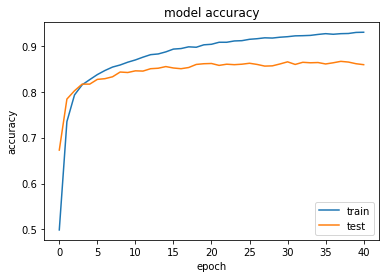

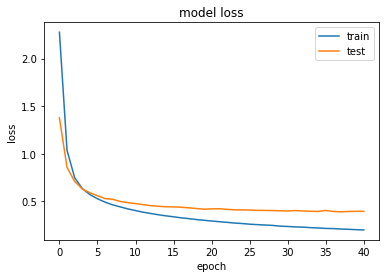

In [29]:
plt.plot(training_results.history['accuracy'])
plt.plot(training_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

plt.plot(training_results.history['loss'])
plt.plot(training_results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [30]:
nl_test_bot_identity = ['uhh wie is je ontwikkelaar?', 'hoe kan ik je bellen', 'wat is je bijnaam ook alweer', 'wat is je echte naam?', 'vertel me je naam?']
nl_test_thanks = ['nou bedankt', 'uhh bedankt voor je hulp', 'hey goed werk', 'uh heel erg bedankt', 'Bravo']
nl_test_volume_up = ['zal hoger spreken', 'kun je harder praten?', 'je praat te stil', 'uh zou je harder kunnen praten', 'ah ik kan je niet goed horen']
nl_test_volume_down = ['zou minder hard praten', 'zal stil praten', 'ah wil je stil praten?', 'kan rustig praten', 'wil je stiller praten?']
nl_test_bot_purpose = ['uh wat is je doel?', 'wat ben je', 'Ben jij een robot?', 'bot of mens?', 'vertel me over jou']
nl_test_greetings = ['o blij je te zien', 'Aangenaam', 'Hallo daar', 'ik ben blij je weer te zien', 'oh goede dag']
nl_test_goodbye = ['oke ik zie je later', 'Welterusten', 'oke doei', 'spreek je later', 'tot ziens']
nl_test_bot_bad = ['je bent een verspilling', 'dit is niet goed', 'Jij bent erg vervelend', 'uh let alsjeblieft op je taal', 'hey je bent gek']
nl_test_tell_me_joke = ['ah vertel me iets grappigs', 'uh ik wil een grap horen', 'uhh ik wil wel een grapje', 'vind een grap in je kluis en vertel het me', 'ah vertel me een willekeurige grap']
nl_test_list_of_games = ['welk spel kunnen we spelen?', 'hey wat kun je nog meer spelen?', 'oh welke games zijn beschikbaar?', 'uhh welk spel ken jij?', 'welk ander spel heb je?']
nl_test_play_other_game = ['ik wil andere spellen openen', 'een ander spel openen', 'hey stop dit spel', 'ik wil dit spel niet spelen', 'laten we wat andere spellen beginnen']
nl_test_response_acknowledgement = ['O ja?', 'je doet?', 'uhh ik zie het', 'denk het?', 'is dat juist']
nl_test_bot_action_directive = ['waarom begin je niet?', 'eh ga door', 'noem maar op', 'hey je moet leren', 'je zou dat kunnen proberen']
nl_test_bot_affection = ['je werkt goed', 'ik vind jou ook leuk', 'trouw met me alsjeblieft', 'jij bent goed', 'ah vind je erg leuk']
nl_test_music_likeness = ['het lied raakt mijn hart', 'hey dit is een vijf sterren nummer!', 'het nummer dat je speelt is geweldig', 'ah ik hou van muziek uit de jaren 80', 'dit is een leuk liedje']
nl_test_negative_reaction = ['wil je dit oplossen?', 'hey ik heb een probleem', 'erger dan ik dacht', 'dit is zo saai', 'behoorlijk slecht']
nl_test_positive_reaction = ['briljant', 'het is zeer goed', 'dat is een goed idee', 'ah geweldig', 'Super geweldig']
nl_test_no_deny_wrong = ['oh nee ik niet', 'niet correct', 'ik heb er geen', 'niet echt', 'niet dit']
nl_test_stop = ['annuleer mijn verzoek', 'wil je alsjeblieft afsluiten', 'niets doen', 'ik wil stoppen', 'wil je er alsjeblieft mee stoppen']
nl_test_i_dont_care = ['vind het echt niet erg', 'zou het niet erg vinden om er een te selecteren', 'iedereen is in orde met mij', 'het kan me niet echt schelen', 'alles is oké voor mij']
nl_test_appreciation = ['leuk', 'dat klinkt best netjes', 'dat klinkt zo mooi', 'dat is veel werk', 'dat is geweldig']
nl_test_affirm_correct = ['je hebt helemaal gelijk', 'het is de waarheid', 'snap het perfect', 'ja je hebt het antwoord precies', 'commando was exact']
nl_test_repeat = ['vertel me nog een keer de laatste alsjeblieft', 'zou je alsjeblieft je laatste zin willen herhalen?', 'stop en probeer het opnieuw', 'laten we het alsjeblieft nog een keer proberen', 'vertel me alsjeblieft nog een keer']
nl_test_general_praise = ['prachtig werk heb je goed gedaan', 'je hebt het goed gedaan bedankt', 'dat is handig dankjewel', 'dat heb je goed gedaan heel erg bedankt', 'dat heb je goed gedaan, ik waardeer het']
nl_test_explain = ['kunt u alstublieft nogmaals verduidelijken?', 'leg verder uit aub', 'het was me niet duidelijk', 'wat bedoelde je ermee?', 'kun je me verder herformuleren op je antwoorden?']
nl_test_youre_not_correct = ['ik heb hier niet om gevraagd', 'het lijkt erop dat het antwoord niet juist was', 'het spijt me maar dat was niet goed', 'uw opdracht was onjuist', 'het spijt me maar dat is niet het juiste antwoord']
nl_test_yes_agree = ['Ja', 'ik ben het er zeker mee eens', 'positief', 'oh ik denk dat', 'oh ja waarschijnlijk']

In [31]:
ru_test_bot_identity = ['я забыл твое имя', 'можешь подсказать свое имя?', 'кто ты?', 'кто создал тебя?', 'как мне стоит называть тебя?']
ru_test_thanks = ['нет, спасибо, это все', 'большое спасибо', 'благодарю', 'отличная работа!', 'я ценю твою помощь']
ru_test_volume_up = ['хмм а не мог бы ты говорить погромче?', 'а можно повысить громкость?', 'я не слышу тебя', 'можешь разговаривать громче?', 'ты говоришь очень тихо']
ru_test_volume_down = ['говори потише', 'ты слишком громкий', 'убавь громкость', 'ты можешь говорить тихо?',  'можно говорить не так громко?']
ru_test_bot_purpose = ['ты можешь мне помочь?', 'как это работает?', 'ты робот?', 'ты настоящий?', 'что ты такое?']
ru_test_greetings = ['очень рад видеть тебя', 'доброе утро', 'привет', 'доброго дня', 'приветствую!']
ru_test_goodbye = ['прощай', 'спасибо, до свидания', 'пока-пока', 'всего хорошего', 'увидимся позже!']
ru_test_bot_bad = ['ты очень плохой', 'ты сошел с ума', 'очень плохо', 'хм, это было ужасно', 'ты просто мусор']
ru_test_tell_me_joke = ['расскажи мне шутку', 'хей ну ка расскажи анекдот', 'ты знаешь какие-нибудь шутеечки?', 'мм я хотел бы услышать шутку', 'я хочу услышать что-нибудь смешное']
ru_test_list_of_games = ['во что я могу поиграть?', 'о, какие игры у тебя есть?', 'в какие игры ты умеешь играть?', 'а в какую игру мы можем поиграть?', 'ммм какие игры доступны?']
ru_test_play_other_game = ['нуу давай сыграем в другую игру', 'давай еще поиграем', 'играем еще', 'я хочу сыграть еще одну игру', 'я хочу начать новую игру']
ru_test_response_acknowledgement = ['правда?', 'действительно?', 'это правильно?', 'не так ли?', 'ух ты']
ru_test_bot_action_directive = ['тебе стоит попробовать', 'ты хочешь начать первым?', 'Вам стоит попытаться', 'тебе нужно научиться этому', 'продолжай']
ru_test_bot_affection = ['ты хорошо работаешь', 'ты хороший', 'Ты мне тоже нравишься', 'ах ты мне очень нравишься', 'женись на мне, пожалуйста']
ru_test_music_likeness = ['а мне нравится музыка 90-х', 'эта песня трогает мое сердце', 'песня, которую ты играешь, потрясающая', 'это хорошая песня', 'Эй, это пятизвездочная песня!']
ru_test_negative_reaction = ['хуже, чем я думал', 'это так скучно', 'ты исправишь это', 'довольно плохо', 'эй у меня проблема']
ru_test_positive_reaction = ['это хорошая идея', 'ах удивительно', 'это очень хорошо', 'супер классно', 'блестяще']
ru_test_no_deny_wrong = ['неправильно', 'У меня нет', 'о нет, я не', 'не совсем', 'не то']
ru_test_stop = ['отменить мой запрос', 'не могли бы вы выключить', 'ничего не делать', 'я хочу остановить это', 'пожалуйста, просто прекрати это']
ru_test_i_dont_care = ['мне все равно', 'мне действительно без разницы', 'не против выбрать любой', 'я согласен на любое', 'любое окей для меня']
ru_test_appreciation = ['это звучит так красиво', 'красивый', 'это много работы', 'это великолепно', 'это звучит довольно аккуратно']
ru_test_affirm_correct = ['вы совершенно правы', 'это правда', 'ваш ответ отличный', 'да вы точно ответили', 'команда была точной']
ru_test_repeat = ['не могли бы вы повторить то, что вы сказали', 'можешь повторить?', 'попробуем еще раз', 'пожалуйста, скажи мне еще раз', 'Я хотел бы снова услышать последнюю фразу' ]
ru_test_general_praise = ['Спасибо за ваш ответ', 'это отличная работа', 'это полезно, я ценю это', 'это полезно, большое спасибо', 'молодец спасибо']
ru_test_explain = ['пожалуйста, поясните мне свои ответы', 'объясни свой ответ мне еще раз, пожалуйста', 'я не совсем это понял', 'Я не понимаю твоих слов', 'я не понимаю этого']
ru_test_youre_not_correct = ['сделай это как-то по-другому', 'я думаю, что ты сделал задание неправильно', 'извините, но это не правильный ответ', 'нет, ты не понял что я спросил', 'ты сделал что-то не так']
ru_test_yes_agree = ['звучит правильно', 'о да, абсолютно', 'о да, вроде того', 'это возможно', 'думаю да']

In [32]:
def predict_top3(value):
    vals = model.predict(np.array([value.lower()]))[0]
    result = [intent_groups[i] for i in sorted(range(len(vals)), key=lambda i: vals[i])[-3:]]
    result.reverse()
    return result

In [33]:
def test_intent(intent, samples):
    correct_count = 0
    in_top3_count = 0
    predicted_instead = []
    print('Testing intent: ' + intent)
    for sample in samples:
        predicted_top3 = predict_top3(sample)
        if intent == predicted_top3[0]: 
            correct_count += 1
        else:
            if intent in predicted_top3:
                in_top3_count += 1
            predicted_instead.append(predicted_top3[0])
            #print('###', sample, '===', predicted_top3[0])

    correct_pct = round(correct_count/len(samples) * 100)
    top3_pct = round(in_top3_count/len(samples) * 100)
    print('correct intents predicted: ', correct_pct, '%')
    print('not correct but in top 3: ', top3_pct, '%')
    print('intents that were predicted instead:', predicted_instead)
    print('--------------------------------')
    return (correct_pct, top3_pct)

In [34]:
test_results = []
test_results.append(test_intent('bot_identity', ru_test_bot_identity + nl_test_bot_identity))
test_results.append(test_intent('thanks', ru_test_thanks + nl_test_thanks))
test_results.append(test_intent('volume_up', ru_test_volume_up + nl_test_volume_up))
test_results.append(test_intent('volume_down', ru_test_volume_down + nl_test_volume_down))
test_results.append(test_intent('bot_purpose', ru_test_bot_purpose + nl_test_bot_purpose))
test_results.append(test_intent('greetings', ru_test_greetings + nl_test_greetings))
test_results.append(test_intent('goodbye', ru_test_goodbye + nl_test_goodbye))
test_results.append(test_intent('bot_bad', ru_test_bot_bad + nl_test_bot_bad))
test_results.append(test_intent('tell_me_joke', ru_test_tell_me_joke + nl_test_tell_me_joke))
test_results.append(test_intent('list_of_games', ru_test_list_of_games + nl_test_list_of_games))
test_results.append(test_intent('play_other_game', ru_test_play_other_game + nl_test_play_other_game))
test_results.append(test_intent('response_acknowledgement', ru_test_response_acknowledgement + nl_test_response_acknowledgement))
test_results.append(test_intent('bot_action_directive', ru_test_bot_action_directive + nl_test_bot_action_directive))
test_results.append(test_intent('bot_affection', ru_test_bot_affection + nl_test_bot_affection)) 
test_results.append(test_intent('music_likeness', ru_test_music_likeness + nl_test_music_likeness)) 
test_results.append(test_intent('negative_reaction', ru_test_negative_reaction + nl_test_negative_reaction)) 
test_results.append(test_intent('positive_reaction', ru_test_positive_reaction + nl_test_positive_reaction)) 
test_results.append(test_intent('no_deny_wrong', ru_test_no_deny_wrong + nl_test_no_deny_wrong)) 
test_results.append(test_intent('stop', ru_test_stop + nl_test_stop)) 
test_results.append(test_intent('i_dont_care', ru_test_i_dont_care + nl_test_i_dont_care)) 
test_results.append(test_intent('appreciation', ru_test_appreciation + nl_test_appreciation)) 
test_results.append(test_intent('affirm_correct', ru_test_affirm_correct + nl_test_affirm_correct)) 
test_results.append(test_intent('repeat', ru_test_repeat + nl_test_repeat)) 
test_results.append(test_intent('general_praise', ru_test_general_praise + nl_test_general_praise)) 
test_results.append(test_intent('explain', ru_test_explain + nl_test_explain)) 
test_results.append(test_intent('youre_not_correct', ru_test_youre_not_correct + nl_test_youre_not_correct)) 
test_results.append(test_intent('yes_agree', ru_test_yes_agree + nl_test_yes_agree)) 

correct_results, top3_results = zip(*test_results)
correct_pct = round(mean(correct_results))
top3_pct = round(mean(top3_results))
print('--------------------------------')
print('--------------------------------')
print('Total result:')
print('correct intents predicted:', correct_pct, '%')
print('not correct but in top 3:', top3_pct, '%')
print('top 1 + top 3:', correct_pct + top3_pct, '%')

Testing intent: bot_identity
correct intents predicted:  80 %
not correct but in top 3:  20 %
intents that were predicted instead: ['bot_purpose', 'list_of_games']
--------------------------------
Testing intent: thanks
correct intents predicted:  80 %
not correct but in top 3:  0 %
intents that were predicted instead: ['appreciation', 'general_praise']
--------------------------------
Testing intent: volume_up
correct intents predicted:  70 %
not correct but in top 3:  20 %
intents that were predicted instead: ['volume_down', 'volume_down', 'stop']
--------------------------------
Testing intent: volume_down
correct intents predicted:  60 %
not correct but in top 3:  40 %
intents that were predicted instead: ['volume_up', 'bot_action_directive', 'volume_up', 'repeat']
--------------------------------
Testing intent: bot_purpose
correct intents predicted:  80 %
not correct but in top 3:  10 %
intents that were predicted instead: ['response_acknowledgement', 'goodbye']
-----------------